## The Training

### 1st train

Runs with data digit images only.
The best model will be stored as "eff100md-best.h5"


## The Model

Used a smaller variant of Efficientnet (effnet) network as small model.

<https://github.com/arthurdouillard/keras-effnet>


In [1]:
########### Basic Parameters for Running: ################################
    
Training_Percentage = 0.2           
Epoch_Anz = 70                      # earlystopping, see model.fit
nb_classes = 100                     # move to 1. step
#input_shape = (32, 20,1)            # will be calculated
Batch_Size = 32
use_grayscale = False                # grayscale or rgb
model_filename = "output/eff100md"

##########################################################################

from sklearn.model_selection import train_test_split
from b2n.data.tmnist import tmnist_percentals
from b2n.data.ziffer import ziffer_data
from b2n.plotfunctions import *
from sklearn.utils import shuffle
from b2n.encodings.class_encoding import *
from b2n.augmentation.generator import *


## Load data

Like the distillation network meter digits will be trained with font builded images.

### digit meter images

The meter digits are all 0-9 ziffer_raw (https://github.com/jomjol/neural-network-autotrain-digital-counter/tree/main/ziffer_raw) and other collected data (used https://github.com/haverland/collectmeterdigits).

### Train and Test data

For 1st train the digit meter will be used.

### digit meter spread

The percental TMNIST has for every label the same count of data.

The images of digit meters are collected and labeled by hand. So the image count of labels are differnt. The meter digit spread plot shows the count for each label.

Ziffer data count:  12476
dataset x_train-size=9980


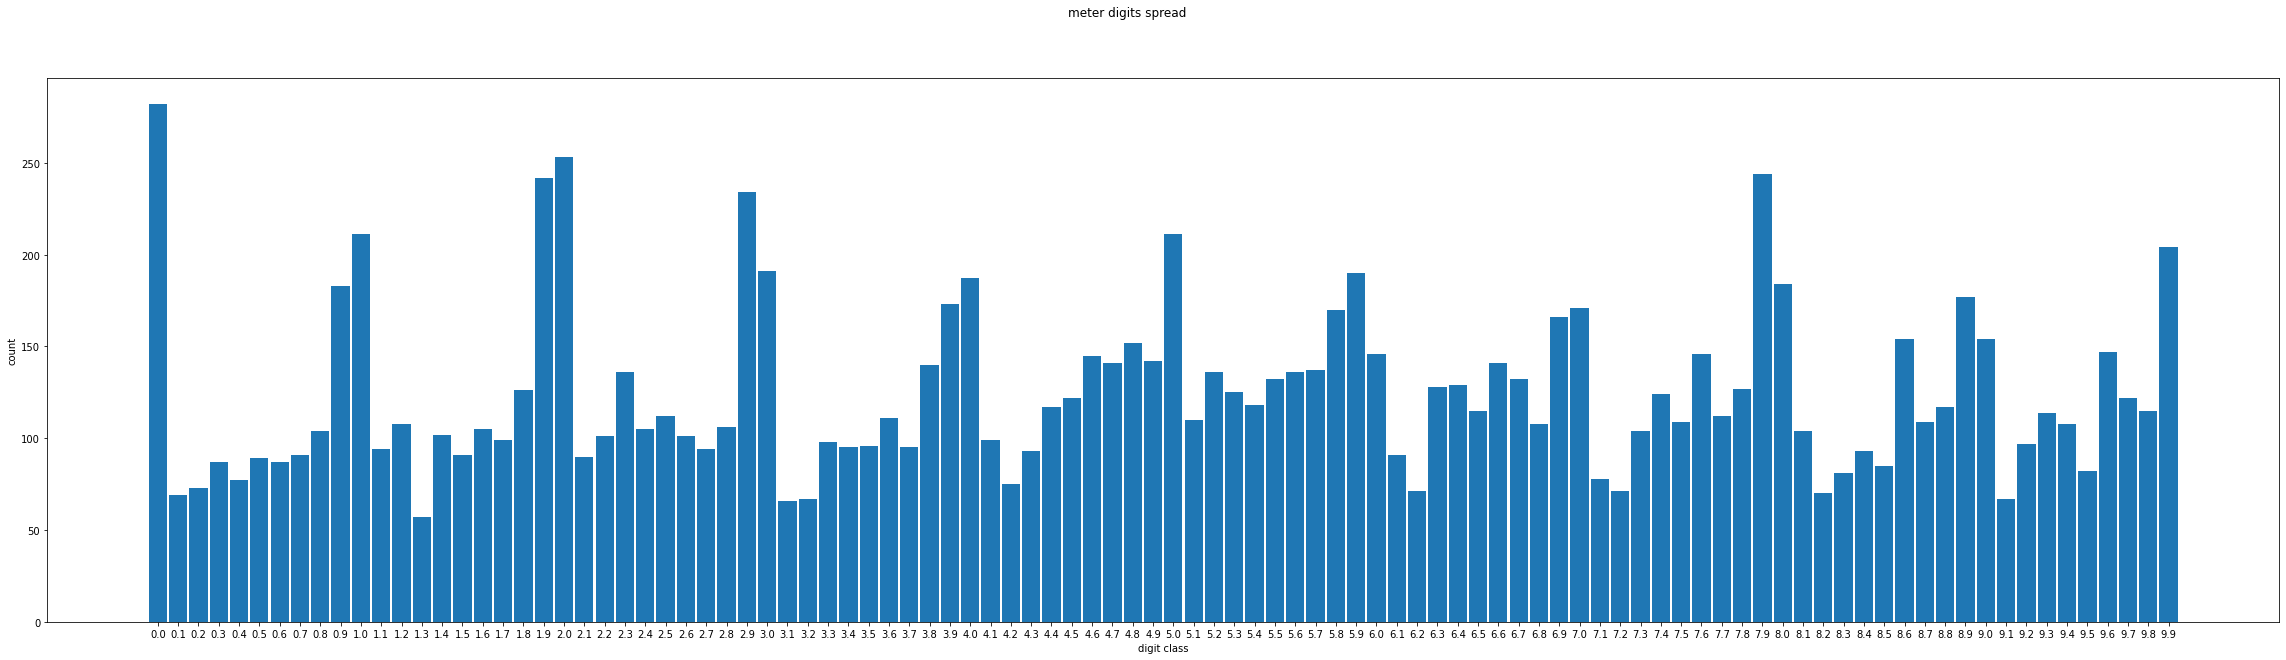

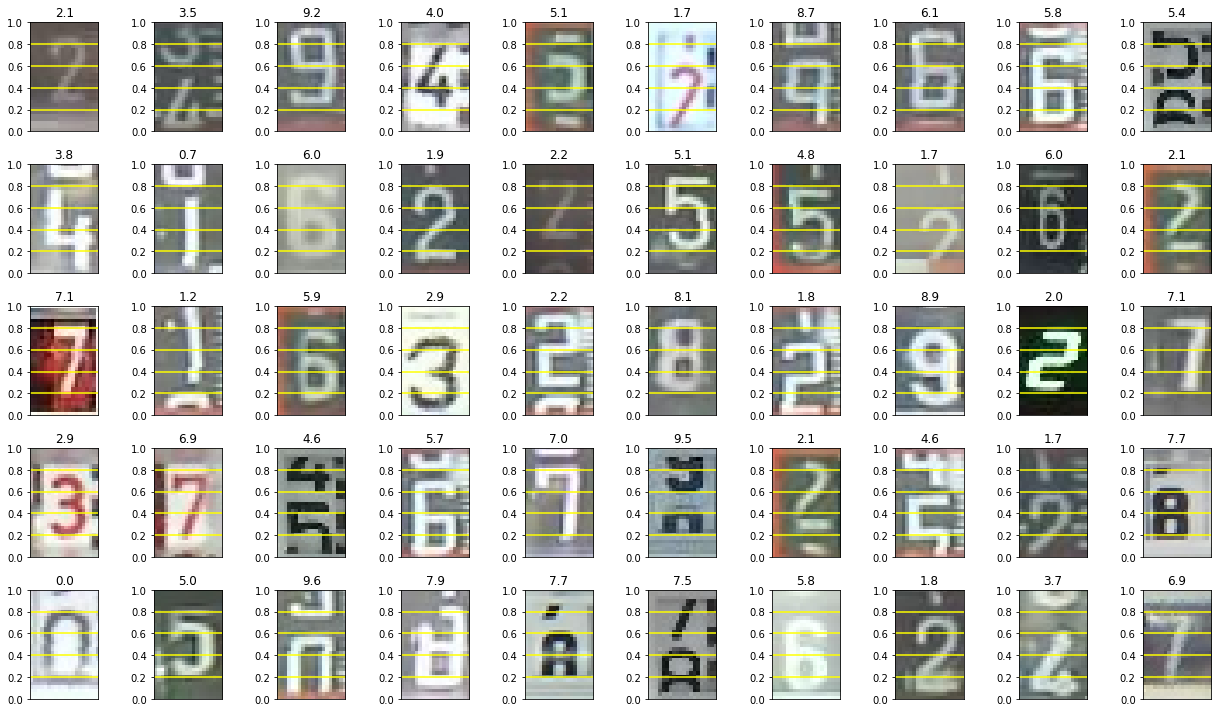

In [2]:


xz_data, yz_data, fz_data = ziffer_data(input_dir='images')

# distribution
_, inverse = np.unique(yz_data, return_inverse=True)
ziffer_bincount = np.bincount(inverse)
plot_divergence(ziffer_bincount, "meter digits spread", nb_classes)


# Split train and validation data 
xz_train, yz_train = shuffle(xz_data, yz_data)
xz_train, xz_test, yz_train, yz_test = train_test_split(xz_train, yz_train, test_size=Training_Percentage)


#xt_data, yt_data = tmnist_percentals()

# mixing the datasets
#x_data = np.concatenate((xt_data, xz_train))
#y_data = np.concatenate((yt_data, yz_train))
x_data, y_data = shuffle(xz_data, yz_data)
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=Training_Percentage)

input_shape=x_train[0].shape
print(f"dataset x_train-size={len(x_train)}")
plot_dataset(x_train, y_train)

y_train = class_encoding(y_train, nb_classes)
y_test = class_encoding(y_test, nb_classes)

yz_train = class_encoding(yz_train, nb_classes)
yz_test = class_encoding(yz_test, nb_classes)


### Augmentation
See augementation above for augmentation values.
Standard augmentation of image generator is used plus inverting and noising images.
Spot light is not used. It makes the train difficult without better results.

The validation set is not augmentated. It uses only meter digit images for a real result how the model fits to meter digits.
So the validation says more about the results and its easier to use a early stopping mechanism.

Train data


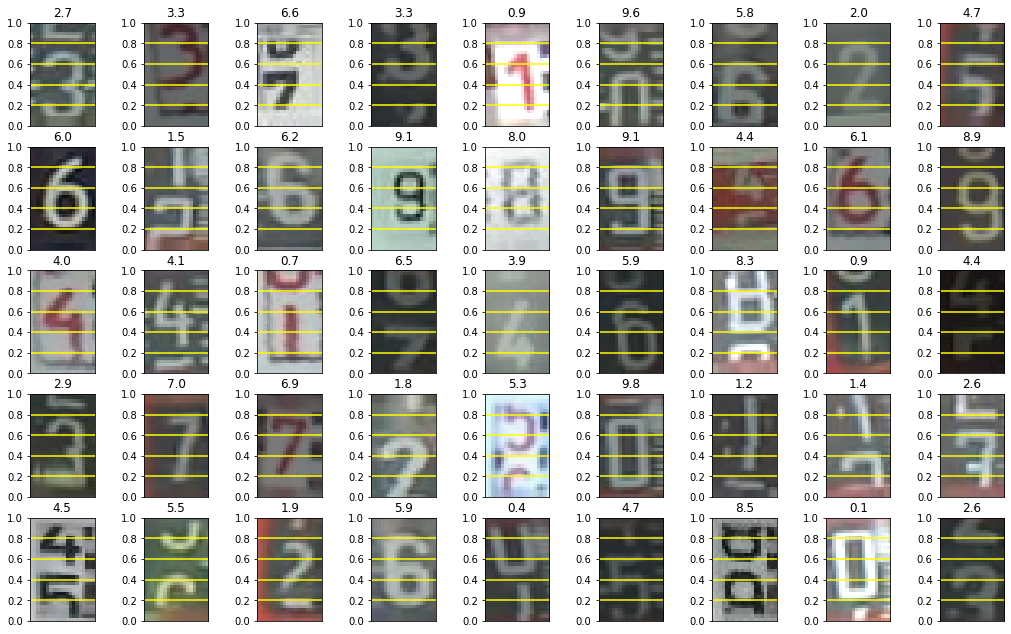

Validation data


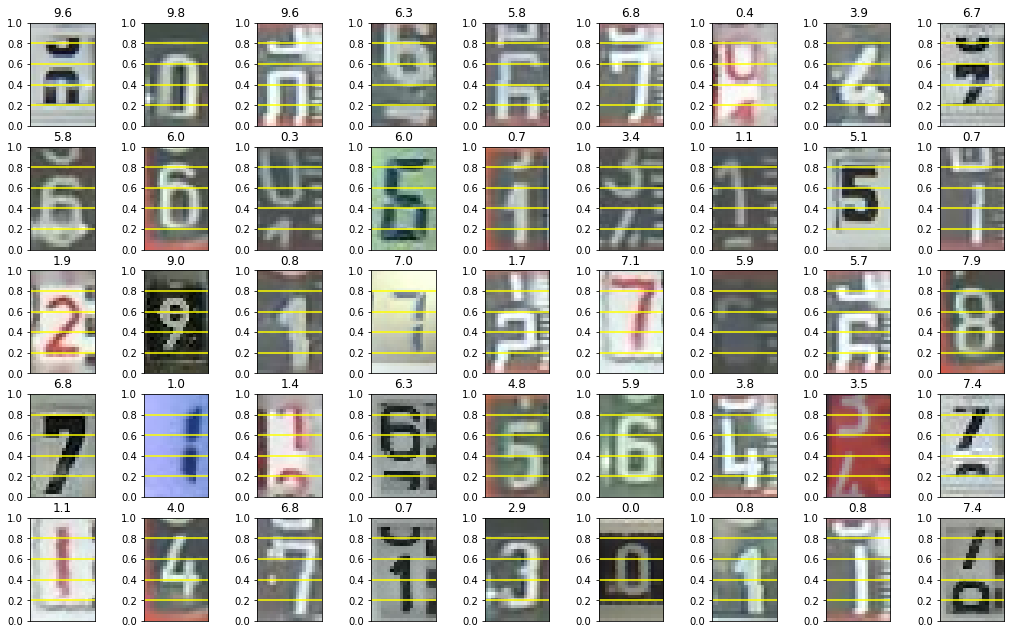

In [3]:
import numpy as np
from b2n.augmentation.generator import augmentation, no_augmentation
from b2n.plotfunctions import plot_dataset_it

train_iterator = augmentation(x_train, y_train, preprocessing_function=None)
validation_iterator = no_augmentation(x_test, y_test)

# train data
print("Train data")
plot_dataset_it(train_iterator)     

# validation data
print("Validation data")
plot_dataset_it(validation_iterator) 


### The Model

Is an small EfficientNet like model with a dense output of 100 at top. 



In [4]:
import tensorflow as tf
from b2n.models.distiller import Distiller
from b2n.models.effnet import Effnet
from b2n.models.cnn32 import *
model = CNN3(input_shape, nb_classes, activation_top=None)

model.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True), 
              optimizer="adam", metrics = ["accuracy"])

Metal device set to: Apple M1 Pro

systemMemory: 32.00 GB
maxCacheSize: 10.67 GB



2022-06-19 11:00:40.378751: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-06-19 11:00:40.378855: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


### The Training

Standard training of the model with complete dataset.

The ModelCheckpoint helps to keep the best model. 

In [5]:
from keras.callbacks import EarlyStopping, LearningRateScheduler, ModelCheckpoint
from b2n.plotfunctions import plot_acc_loss, predict_meter_digits

annealer = LearningRateScheduler(lambda x: 1e-3 * 0.98 ** x, verbose=0)
earlystop = EarlyStopping(monitor='val_loss', mode='min' , patience=25, verbose=1,  restore_best_weights=True)
mc = ModelCheckpoint(model_filename + '_best.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

history = model.fit(train_iterator, 
                validation_data=validation_iterator, 
                batch_size=Batch_Size, 
                epochs = Epoch_Anz,
                callbacks=[annealer, earlystop, mc],
                verbose=1)


model.save(model_filename + '.h5')

plot_acc_loss(history, "Trainingsresults")

Epoch 1/70


2022-06-19 11:00:40.556042: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-06-19 11:00:40.852133: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


308/312 [============================>.] - ETA: 0s - loss: 4.6623 - accuracy: 0.0180

KeyboardInterrupt: 

### Validate on all digit meter

Because of the small dataset of meter digits all meter digits are used for validation

In [ ]:
fz_data

In [ ]:
model = keras.models.load_model(model_filename + '_best.h5')
false_predicted_files = predict_meter_digits(model, x_data=xz_data, y_data=yz_data, f_data=fz_data, max_delta=0.14)
fpf = pd.DataFrame(false_predicted_files)
fpf.to_csv(model_filename + '_false_predicted.csv')

### 2nd train

Now the model will be trained like transfer learning <https://keras.io/guides/transfer_learning/>.

All layers except the top layer will be fixed and not trained in the 2nd training.

As dataset the digit meter images are used.

In [ ]:
import numpy as np


# now whith meter digits
train_iterator = augmentation(xz_train, yz_train)
validation_iterator = no_augmentation(xz_test, yz_test)

# train data
print("Train data")
plot_dataset_it(train_iterator)     

# validation data
print("Validation data")
plot_dataset_it(validation_iterator) 

# only the last layer is now trainable
for layer in model.layers[:-1]:
    layer.trainable=False

mc = ModelCheckpoint(model_filename + '_best_transfer.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

model.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True), 
              optimizer="adam", metrics = ["accuracy"])

history = model.fit(train_iterator, 
                validation_data=validation_iterator, 
                batch_size=Batch_Size, 
                epochs = 2,
                callbacks=[annealer, earlystop, mc],
                verbose=2)


model.save(model_filename + "_best_transfer.h5")

plot_acc_loss(history, "Trainingsresults")


### Validate on all digit meter

Because of the small dataset of meter digits all meter digits are used for validation

In [ ]:
model = keras.models.load_model(model_filename + "_best_transfer.h5")
predict_meter_digits(model, x_data=xz_data, y_data=yz_data, f_data=fz_data)